In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from graph_reinforcement_learning_using_blockchain_data import config
from graph_reinforcement_learning_using_blockchain_data.modeling import random_forest

config.load_dotenv()

2025-03-13 20:16:00.538 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:11 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


True

In [2]:
df_features = pd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges.csv"
)
df_embeddings = pd.read_csv(config.FLASHBOTS_Q2_DATA_DIR / "embeddings_128.csv")

In [3]:
df_embeddings.head()

,transactionHash,embeddings
0,0x8e90ecb85b61af368db0154830453552f0c27e0e1812...,[ 0.6488047 0.8857084 0.80789745 0.175188...
1,0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...,[-1.01943046e-01 -1.50753886e-01 -1.45948857e-...
2,0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...,[ 0.6488047 0.8857084 0.80789745 0.175188...
3,0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...,[ 0.6488047 0.8857084 0.80789745 0.175188...
4,0x78d66376b7f4cd481a31ccd9b4c1440259695cb2e5d2...,[ 1.0032636 1.0859172 0.8387185 0.493998...


In [4]:
def parse_embedding(embedding_str):
    embedding_str = embedding_str.replace("\n", " ")
    embedding_array = np.fromstring(embedding_str.strip("[]"), sep=" ")
    return embedding_array


df_embeddings["embeddings"] = df_embeddings["embeddings"].apply(parse_embedding)

In [5]:
embedding_list = df_embeddings["embeddings"].tolist()
embedding_dim = embedding_list[0].shape[0]  # e.g. 128

embeddings_expanded = pd.DataFrame(
    embedding_list, columns=[f"emb_{i}" for i in range(embedding_dim)]
)
embeddings_expanded["transactionHash"] = df_embeddings["transactionHash"].values

In [6]:
embeddings_expanded.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,transactionHash
0,0.648805,0.885708,0.807897,0.175189,0.342610,0.690774,0.613281,-0.737558,-0.445017,-0.844519,...,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089,0x8e90ecb85b61af368db0154830453552f0c27e0e1812...
1,-0.101943,-0.150754,-0.145949,-0.222893,-0.101609,-0.088858,-0.120292,0.223810,0.122644,0.105553,...,0.087557,0.063972,0.171073,0.106778,-0.096407,0.173654,0.108045,0.091411,0.204592,0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...
2,0.648805,0.885708,0.807897,0.175189,0.342610,0.690774,0.613281,-0.737558,-0.445017,-0.844519,...,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089,0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...
3,0.648805,0.885708,0.807897,0.175189,0.342610,0.690774,0.613281,-0.737558,-0.445017,-0.844519,...,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089,0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...
4,1.003264,1.085917,0.838719,0.493998,1.003514,1.077829,0.926629,-1.344079,-1.026231,-1.244821,...,-1.244183,-0.525696,-0.923329,-1.299295,0.577549,-0.721241,-1.122780,-1.086308,-0.922723,0x78d66376b7f4cd481a31ccd9b4c1440259695cb2e5d2...


In [7]:
df_merged = df_features.merge(embeddings_expanded, how="inner", on="transactionHash")

In [8]:
# df_merged = df_merged[df_merged["num_logs"].apply(lambda x: x is not None and x > 0)]

df_merged.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,0x8e90ecb85b61af368db0154830453552f0c27e0e1812...,17005294,153529,10750253,111,19150328915,1,2940130847991035,0x832aC338d06f5A438f3340B724c08C44e744e9c2,0x00000000000001ad428e4906aE43D8F9852d0dD6,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
1,0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...,16962424,123497,229900,1,139502435999,1,17228132338568503,0x080086911D8c78008800FAE75871a657b77d0082,0x0000E0Ca771e21bD00057F54A68C30D400000000,...,-0.138172,0.087557,0.063972,0.171073,0.106778,-0.096407,0.173654,0.108045,0.091411,0.204592
2,0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...,16972733,46817,14885776,165,18825121161,1,881335697394537,0xCA8ba7d3f798d1872A8C05c5358a1b24a4d3Ac64,0x2b591e99afE9f32eAA6214f7B7629768c40Eeb39,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
3,0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...,17028487,32215,3160909,48,19660583885,1,633365709855275,0x8FEf490D614fCe8B93Bd6F28835dD35a8B3229a9,0xBA50933C268F567BDC86E1aC131BE072C6B0b71a,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
4,0x78d66376b7f4cd481a31ccd9b4c1440259695cb2e5d2...,17067044,153886,9279317,110,45282851253,1,6968396847919158,0xc94893b6D1CC1d7ce09Fec6abC9B5949A903d2C9,0xEf1c6E67703c7BD7107eed8303Fbe6EC2554BF6B,...,1.046832,-1.244183,-0.525696,-0.923329,-1.299295,0.577549,-0.721241,-1.122780,-1.086308,-0.922723


In [9]:
df = df_merged.drop(columns=["transactionHash", "from", "to", "blockNumber", "transactionIndex"])
df.head()

,gasUsed,cumulativeGasUsed,effectiveGasPrice,status,fee,num_logs,dummy_0xd78ad95f,dummy_0xe1fffcc4,dummy_0x908fb5ee,dummy_0xe9149e1b,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,153529,10750253,19150328915,1,2940130847991035,3,0,0,0,0,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
1,123497,229900,139502435999,1,17228132338568503,7,1,0,0,0,...,-0.138172,0.087557,0.063972,0.171073,0.106778,-0.096407,0.173654,0.108045,0.091411,0.204592
2,46817,14885776,18825121161,1,881335697394537,1,0,0,0,0,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
3,32215,3160909,19660583885,1,633365709855275,1,0,0,0,0,...,0.703639,-0.676612,-0.518422,-0.524117,-0.732895,0.692418,-0.523640,-0.374066,-0.332854,-0.970089
4,153886,9279317,45282851253,1,6968396847919158,5,0,1,0,0,...,1.046832,-1.244183,-0.525696,-0.923329,-1.299295,0.577549,-0.721241,-1.122780,-1.086308,-0.922723


In [10]:
X = df.drop(columns=["label"])
# X = np.hstack([other_features, embedding_matrix])
y = df["label"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
features_to_scale = ["gasUsed", "cumulativeGasUsed", "effectiveGasPrice", "fee", "num_logs"]

In [13]:
rf_trainer = random_forest.RandomForestTrainer()
grid_search = rf_trainer.grid_search(features_to_scale)

In [14]:
best_model = rf_trainer.train(
    X_train, X_test, y_train, y_test, grid_search, "Edge Classification with GNN embeddings"
)

2025/03/13 20:16:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=100; total time=  24.0s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=  15.0s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  28.3s
[CV] END classifier__max_depth=20, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time= 9.1min
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=200; total time=  42.1s
[CV] END classifier__max_depth=30, clas

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=  48.4s
[CV] END classifier__max_depth=20, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time= 4.5min
[CV] END classifier__max_depth=20, classifier__max_features=None, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 4.4min
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=200; total time=  40.3s
[CV] END classifier__max_depth=30, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 5.2min
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, cl

2025/03/13 20:45:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).
"
2025/03/13 20:45:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/ve

🏃 View run sedate-lamb-613 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/eac0f4c268534f48b84f2b6158a9309e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575
🏃 View run chill-koi-78 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/3b94cd394d2c4968aa0fe7b25242e261
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575
🏃 View run exultant-sow-462 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/b684e115f7fa49bd958346190ec7163c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575
🏃 View run mercurial-loon-16 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/f37656eaa7784e3997508a9ad0d2b0da
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575
🏃 View run efficient-fowl-422 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/9323c160449943bca2ed4ca72cfc57b4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/96099835871

2025/03/13 20:45:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


🏃 View run rebellious-moth-166 at: http://127.0.0.1:8080/#/experiments/960998358711185575/runs/5cdb567944334deebb164cac401932f5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/960998358711185575


In [15]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE score: {-grid_search.best_score_:.3f}")

Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': None, 'classifier__max_depth': 30}
Best RMSE score: -0.989


In [16]:
rf = best_model

In [17]:
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))

Train Accuracy: 0.9925186701039147
Test Accuracy: 0.9900074412671415


In [18]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

2025/03/13 20:45:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14926
           1       0.98      1.00      0.99     22702

    accuracy                           0.99     37628
   macro avg       0.99      0.99      0.99     37628
weighted avg       0.99      0.99      0.99     37628



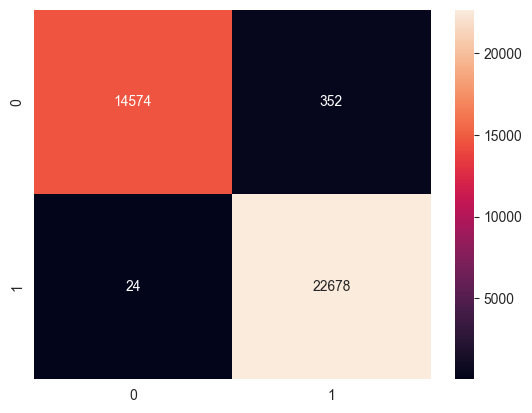

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

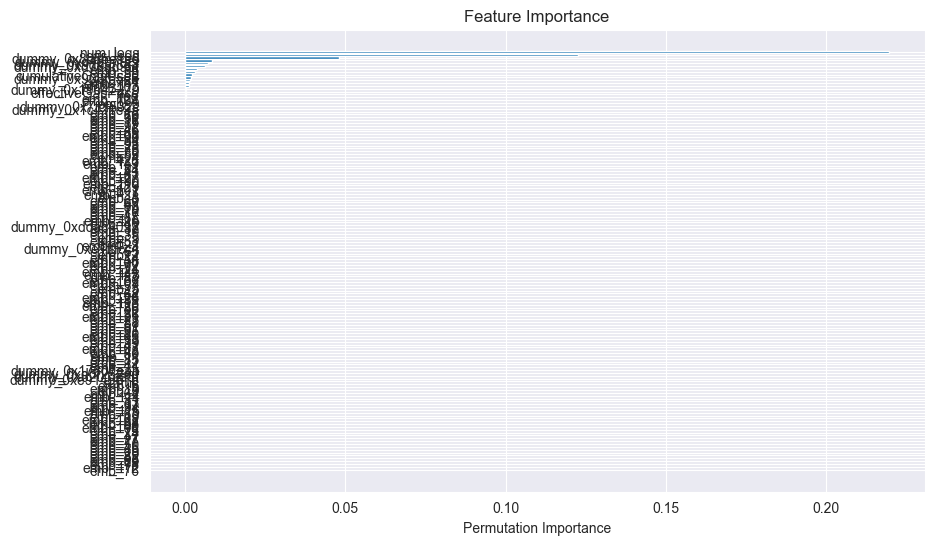

In [20]:
perm_importance = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()